In [2]:
import sys
sys.path.append("..")
import os
os.chdir("..")

In [14]:
os.chdir('git/neural-analysis')

In [3]:
# load model from cache
# sample
import shelve
from conf import Conf
import main
import models
import data_manager
import features_lib

nid = 72
data = data_manager.Loader5()(nid)
dataprop = data_manager.DataProp1(data)

m = models.AlloModel(n_bats=5, max_iter=25, fit_intercept=False)
d = shelve.open(Conf().CACHE_FOLDER + "models")
k = models.ModelledNeuron(m, main.nid, shuffle_index=0)
m = d[k.get_key()].model

In [48]:
covariate_list = set(m.build_covariates_list()) & set(dataprop.data.columns)
X = dataprop.data[covariate_list]
y = dataprop.data[features_lib.get_label_name()]
samples = m.gam_model.sample(X, y, quantity='coef', n_bootstraps=1, n_draws=1000)

In [54]:
import numpy as np
from copy import deepcopy
import time

m2 = deepcopy(m)
mean_sample = np.mean(samples, axis=0)

def get_loglikelihood_per_sample(sample):
    m2.gam_model.coef_ = sample
    ll = m2.gam_model.loglikelihood(X, y)
    return ll

t = time.time()
print(get_loglikelihood_per_sample(samples[0]))
t2 = time.time()
print(t2 - t)
print(get_loglikelihood_per_sample(samples[1]))
t3 = time.time()
print(t3 - t2)

pDIC = 2*get_loglikelihood_per_sample(mean_sample) - 2*np.mean(list(map(get_loglikelihood_per_sample, samples)))
dic = -2*get_loglikelihood_per_sample(mean_sample) + 2*pDIC
print(dic)

-91625.01889627487
1.30251145362854
-108701.25542037014
1.3174755573272705
206937.87316468483


In [23]:
np.ones_like((100, 200, 300))

array([1, 1, 1])

In [53]:
np.finfo(float).eps

2.220446049250313e-16

In [88]:
import numpy as np
from copy import deepcopy
import time

m_ego = models.EgoModel(n_bats=5, max_iter=25, fit_intercept=True)
m_ego.neuron_id = main.nid

cache = {}
from scipy.stats import poisson
def get_loglikelihood_per_sample(m, sample):
    if tuple(sample) not in cache:
        global X, y
        m2 = deepcopy(m)
        m2.gam_model.coef_ = sample
        weights = np.ones_like(mu)
        y_pred = m2.gam_model.predict(X)
        eps = np.finfo(float).eps
        #ll = np.log((poisson.pmf(y, y_pred))).sum()
        #cache[tuple(sample)] = ll
        #return ll
        ll_ = np.log(eps+poisson.pmf(y, y_pred))#.sum()
        cache[tuple(sample)] = m2.gam_model.loglikelihood(X, y)
        # print("my ll test:", ll_.sum(), cache[tuple(sample)])
        # print("predictions:", y_pred[:10])
        # print("actual rates:", y[:10])
        # print("likelihoods:", np.exp(ll_[:10]))
        # print("loglikelihoods:", ll_[:10])
    # print(cache[tuple(sample)])
    return cache[tuple(sample)]

def calc_dic(m, nid):
    global samples
    
    k = models.ModelledNeuron(m, nid, shuffle_index=0)
    d = shelve.open(Conf().CACHE_FOLDER + "models")

    m = d[k.get_key()].model
    # return m
    # m.gam_model.summary()
    # return (m.gam_model)
    covariate_list = sorted(set(m.build_covariates_list()) & set(dataprop.data.columns))
    print(covariate_list)
    X = dataprop.data[covariate_list]
    y = dataprop.data[features_lib.get_label_name()]
    samples = m.gam_model.sample(X, y, quantity='coef', n_bootstraps=1, n_draws=1000)

    print("<UNSTABLE> Original model ll:",  m.gam_model.loglikelihood(X, y))
    print("Original Model LL:", get_loglikelihood_per_sample(m, m.gam_model.coef_))
    print("SELF LL:", m.gam_model.statistics_['loglikelihood'])
    
    m2 = deepcopy(m)
    mean_sample = np.mean(samples, axis=0)
    print("mean sample ll':", get_loglikelihood_per_sample(m2, mean_sample))
    print("original model ll':",  get_loglikelihood_per_sample(m2, m2.gam_model.coef_))
    mean_ll = get_loglikelihood_per_sample(m2, mean_sample)
    distribution_ll = list(map(lambda x: get_loglikelihood_per_sample(m2, x), samples))
    pDIC_ego = 2 * mean_ll - 2 * np.mean(distribution_ll) # effective number of params
    dic_ego = -2*mean_ll + 2 * pDIC_ego
    print("ll of best model:", np.max(list(map(lambda x: get_loglikelihood_per_sample(m ,x), samples))))
    best_model_coeff = samples[np.argmax(list(map(lambda x: get_loglikelihood_per_sample(m ,x), samples)))]
    best_model = deepcopy(m)
    best_model.gam_model.coef_ = best_model_coeff
    best_model.y_pred = best_model.gam_model.predict(X)
    # k.model.y_pred = k.model.gam_model.predict(X)
    from main import calc_maps_and_plot_models
    import rate_maps
    # data = data_manager.Loader6()(m_ego.neuron_id)
    # dataprop = data_manager.DataProp1(data)
    data_maps = rate_maps.build_maps(dataprop)
    import matplotlib.pyplot as plt
    # plt.figure(figsize=(12, 8), dpi=80)
    plt.rcParams["figure.figsize"] = (20, 16)
    
    # calc_maps_and_plot_models(dataprop, data_maps, [models.ModelledNeuron(m, k.neuron_id, k.shuffle_index),\
    #                                                models.ModelledNeuron(best_model, k.neuron_id, k.shuffle_index)])
    
    print(pDIC_ego, dic_ego)
    print(m.gam_model.statistics_['edof'])
    return dic_ego



In [43]:
p = model1.gam_model.predict(X)
lp = model1.gam_model._linear_predictor(X)
mu = model1.gam_model.link.mu(lp, model1.gam_model.distribution)
print(mu == p)

[ True  True  True ...  True  True  True]


In [40]:
model1.gam_model.predict_mu??

Signature: model1.gam_model.predict_mu(X)
Source:   
    def predict_mu(self, X):
        """
        preduct expected value of target given model and input X

        Parameters
        ---------
        X : array-like of shape (n_samples, m_features),
            containing the input dataset

        Returns
        -------
        y : np.array of shape (n_samples,)
            containing expected values under the model
        """
        if not self._is_fitted:
            raise AttributeError('GAM has not been fitted. Call fit first.')

        X = check_X(X, n_feats=self.statistics_['m_features'],
                    edge_knots=self.edge_knots_, dtypes=self.dtype,
                    features=self.feature, verbose=self.verbose)

        lp = self._linear_predictor(X)
        return self.link.mu(lp, self.distribution)
File:      c:\users\itayy.wismain\appdata\local\programs\python\python310\lib\site-packages\pygam\pygam.py
Type:      method


In [90]:
import models

nid = 72
data = data_manager.Loader6()(nid)
dataprop = data_manager.DataProp1(data)


sub_models = [
    models.AlloModel(n_bats=5, max_iter=25, fit_intercept=True),
    models.EgoModel(n_bats=5, max_iter=25, fit_intercept=True)
    ]

for m in sub_models:
    print(m.__class__)
    covariate_list = sorted(set(m.build_covariates_list()) & set(dataprop.data.columns))
    X = dataprop.data[covariate_list]
    y = dataprop.data[features_lib.get_label_name()]

    dic_allo = calc_dic(m, nid)

<class 'models.AlloModel'>
['BAT_0_F_HD', 'BAT_0_F_X', 'BAT_0_F_Y', 'BAT_1_F_X', 'BAT_1_F_Y', 'BAT_2_F_X', 'BAT_2_F_Y', 'BAT_3_F_X', 'BAT_3_F_Y', 'BAT_4_F_X', 'BAT_4_F_Y']
<UNSTABLE> Original model ll: -22939.07367484442
Original Model LL: -22939.07367484442
SELF LL: -22939.07367484442
mean sample ll': -22939.07688908465
original model ll': -22939.07367484442
ll of best model: -22940.309601719127
26.72497190854483 45931.60372198639
30.665896555045716
<class 'models.EgoModel'>
['BAT_1_F_A', 'BAT_1_F_D', 'BAT_2_F_A', 'BAT_2_F_D', 'BAT_3_F_A', 'BAT_3_F_D', 'BAT_4_F_A', 'BAT_4_F_D']
<UNSTABLE> Original model ll: -23189.784455393714
Original Model LL: -23189.784455393714
SELF LL: -23189.784455393714
mean sample ll': -23189.890704405792
original model ll': -23189.784455393714
ll of best model: -23198.40375641847
45.316244673143956 46470.41389815787
50.31668568633927


In [85]:
model1.gam_model.summary()

PoissonGAM                                                                                                
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                     19.9868
Link Function:                          LogLink Log Likelihood:                                  -764.8311
Number of Samples:                        67006 AIC:                                             1569.6357
                                                AICc:                                            1569.6495
                                                UBRE:                                               2.0136
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.7613
Feature Function                  Lam

C:\Users\ITAYY~1.WIS\AppData\Local\Temp/ipykernel_11636/656752670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  model1.gam_model.summary()


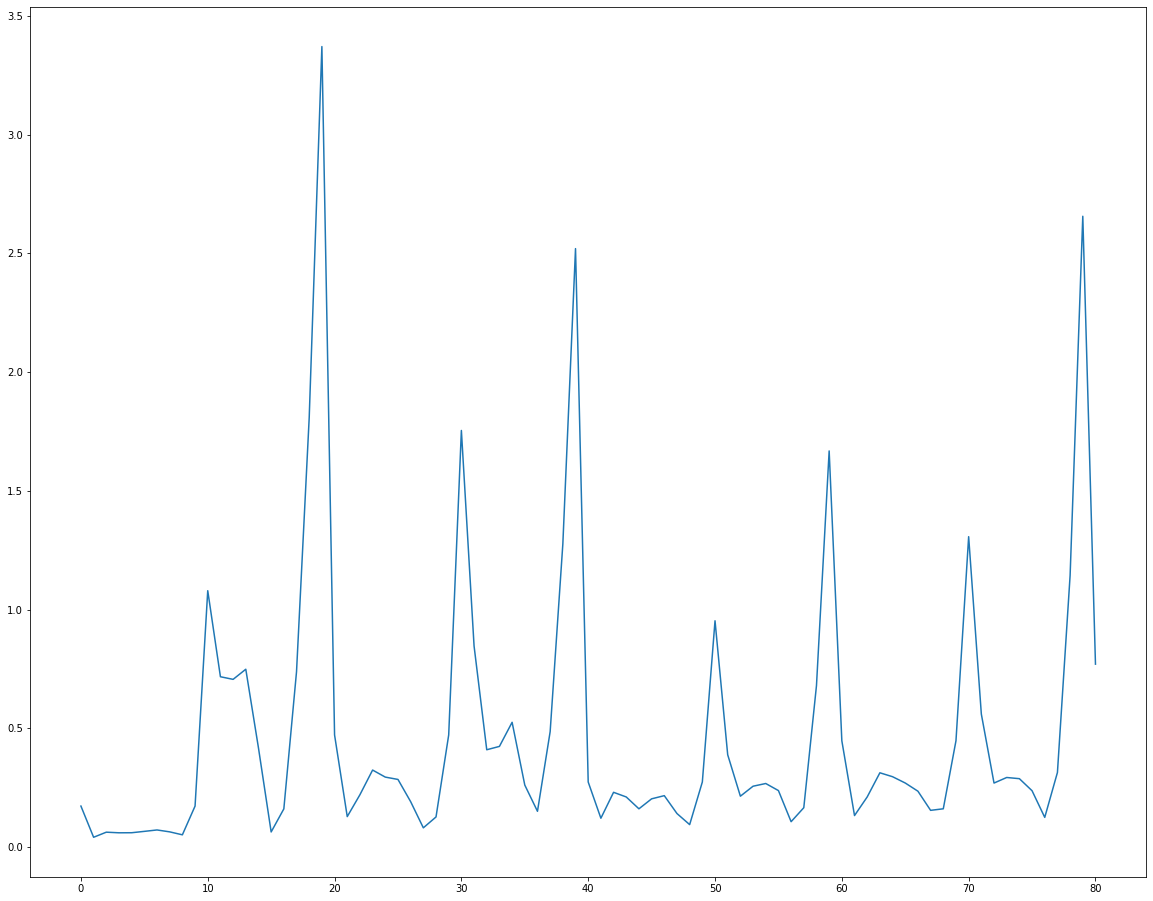

In [189]:
import matplotlib.pyplot as plt
plt.plot(np.diag(train_model.statistics_['cov']))

In [176]:
dic_allo??

Signature:
dic_allo(
    X,
    y,
    quantity='y',
    sample_at_X=None,
    weights=None,
    n_draws=100,
    n_bootstraps=5,
    objective='auto',
)
Source:   
    def sample(self, X, y, quantity='y', sample_at_X=None,
               weights=None, n_draws=100, n_bootstraps=5, objective='auto'):
        """Simulate from the posterior of the coefficients and smoothing params.

        Samples are drawn from the posterior of the coefficients and smoothing
        parameters given the response in an approximate way. The GAM must
        already be fitted before calling this method; if the model has not
        been fitted, then an exception is raised. Moreover, it is recommended
        that the model and its hyperparameters be chosen with `gridsearch`
        (with the parameter `keep_best=True`) before calling `sample`, so that
        the result of that gridsearch can be used to generate useful response
        data and so that the model's coefficients (and their covariance matrix)

In [113]:
m = 
m.neuron_id = 1002
k = get_key_per_model(m)
m = d[k]
dic_ego = calc_dic(m)

NameError: name 'get_key_per_model' is not defined

In [74]:
get_loglikelihood_per_sample(mean_sample)

-2283063.1374242883

In [68]:
d = shelve.open(Conf().CACHE_FOLDER + "models")
for i in list(d.keys()):
    if i.startswith("Ego") and "72" in i:
        print(i)
print(k_ego)

EgoModel|['BAT_2_F_A', 'BAT_2_F_D']|72|0
EgoModel|['BAT_2_F_A', 'BAT_2_F_D']|72|10000
EgoModel|['BAT_1_F_A', 'BAT_1_F_D', 'BAT_2_F_A', 'BAT_2_F_D', 'BAT_3_F_A', 'BAT_3_F_D', 'BAT_4_F_A', 'BAT_4_F_D']|72|0
EgoModel|['BAT_1_F_A', 'BAT_1_F_D', 'BAT_2_F_A', 'BAT_2_F_D', 'BAT_3_F_A', 'BAT_3_F_D', 'BAT_4_F_A', 'BAT_4_F_D']|72|0
